# Heighth exercice: Non-Cartesian 3D under-sampling

In this notebook, you can play with the design parameters to regenerate different 3D sampling in-out patterns (so, we draw as many spiral arches as the number of shots). You can play with the number of shots by changing the under-sampling factor.

- Author: Philippe Ciuciu (philippe.ciuciu@cea.fr) & Pierre-Antoine Comby (pierre-antoine.comby@ens-paris-saclay.fr)
- Date: 01/30/2024 (dependence on MRI-NUFFT for 3D trajectories and NUFFT operators with density compensation)
- Target: ATSI MSc students at Paris-Saclay University


In [2]:
import brainweb_dl as bwdl
import numpy as np
import matplotlib.pyplot as plt

import mrinufft
from mrinufft import display_2D_trajectory, display_3D_trajectory
from mrinufft import get_density, get_operator, check_backend

In [3]:
def _fit_grid(n_tiles):
    """Give the number of row and columns to optimally fit n_tiles."""
    n_rows = int(np.sqrt(n_tiles))
    n_cols = n_rows
    while n_rows * n_cols < n_tiles:
        if n_rows < n_cols:
            n_rows += 1
        else:
            n_cols += 1
    return n_rows, n_cols

def tile_view(
    array,
    axis=-1,
    samples=-1,
    n_rows=-1,
    n_cols=-1,
    img_w=3,
    fig=None,
    cmap="gray",
    axis_label=None,
):
    """Plot a 3D array as a tiled grid of 2D images.

    Parameters
    ----------
    array: numpy.ndarray
        A 3D array
    axis: int
        the axis on which to performs the sampling
    samples: int or float, default: -1
        If int, represent the number of equaly sample to take along axis.
        If float, must be in (0, 1], and represent the sampling rate.
    n_rows int, default=-1
    n_cols int, default=-1
    img_w: int
        size in inches of a sample tile.
    fig: Figure handle, default None
        If None, a new figure is created.
    cmap: matplotlib colormap.
        color map to use.

    Returns
    -------
    matplotlib.pyplot.figure
        The figure handle

    Raises
    ------
    ValueError
        If array is not 3D
    ValueError
        If both n_rows and n_cols are specified and cannot fit the samples.
    """
    if array.ndim != 3:
        raise ValueError("Only 3D array are supported.")
    if axis < 0:
        axis = 3 + axis

    slicer = [slice(None), slice(None), slice(None)]
    axis_label = axis_label or ["t", "x", "y", "z"][axis]

    if samples == -1:
        samples_loc = np.arange(array.shape[axis])
        step = 1
    elif isinstance(samples, int):
        step = array.shape[axis] // (samples + 1)

        samples_loc = np.arange(1, samples + 1) * step
    elif isinstance(samples, float) and (0 < samples <= 1):
        n_samples = int(array.shape[axis] * samples)
        step = array.shape[axis] // n_samples
        samples_loc = np.arange(0, n_samples) * step
    else:
        raise ValueError("Unsupported value for sample")
    n_samples = len(samples_loc)
    array_list = [array[(*slicer[:axis], s, *slicer[axis + 1 :])] for s in samples_loc]

    if n_rows == -1 and n_cols != -1:
        while n_rows * n_cols < n_samples:
            n_rows += 1
    elif n_rows != -1 and n_cols == -1:
        while n_rows * n_cols < n_samples:
            n_cols += 1
    elif n_rows == -1 and n_cols == -1:
        n_rows, n_cols = _fit_grid(n_samples)
    elif n_rows != -1 and n_cols != -1 and n_rows * n_cols < n_samples:
        raise ValueError("The grid is not big enough to fit all samples.")

    aspect_ratio = array_list[0].shape[0] / array_list[0].shape[1]

    fig = plt.figure(num=fig, figsize=(n_cols * img_w, n_rows * img_w * aspect_ratio))
    gs = fig.add_gridspec(
        n_rows,
        n_cols,
        hspace=0.01,
        wspace=0.01,
    )
    axs_2d = gs.subplots(squeeze=False)

    axs = axs_2d.flatten()
    for i, img in enumerate(array_list):
        ax = axs[i]
        ax.axis("off")
        if np.any(np.iscomplex(img)):
            ax.imshow(abs(img), cmap=cmap, origin="lower")
        else:
            ax.imshow(img, cmap=cmap, origin="lower")
        ax.text(
            0.05,
            0.95,
            f"{axis_label}={step*i}",
            ha="left",
            va="top",
            transform=ax.transAxes,
            bbox=dict(boxstyle="square, pad=0", fc=fig.get_facecolor(), ec="none"),
        )
    # remove unused axis
    for ax in axs[len(array_list) :]:
        ax.remove()
    return fig

(181, 256, 256)


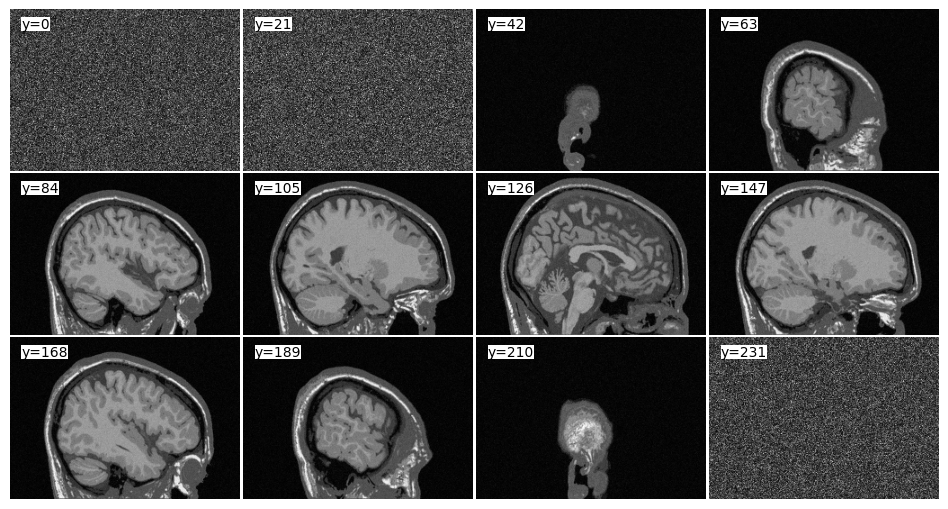

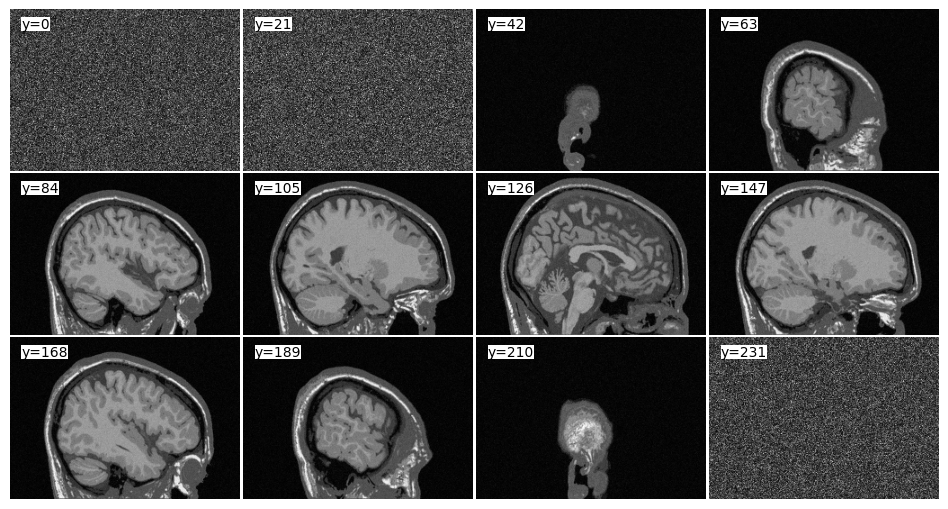

In [4]:
mri_3D = bwdl.get_mri(4, "T1").astype(np.float32)
print(mri_3D.shape)
#plt.imshow(abs(mri_3D))
tile_view(mri_3D, samples=0.05, axis=-1)

In [5]:
def show_trajectory(trajectory, one_shot, figure_size):
    ax = display_3D_trajectory(
        trajectory, size=figure_size, one_shot=one_shot, per_plane=False
    )
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    plt.show()

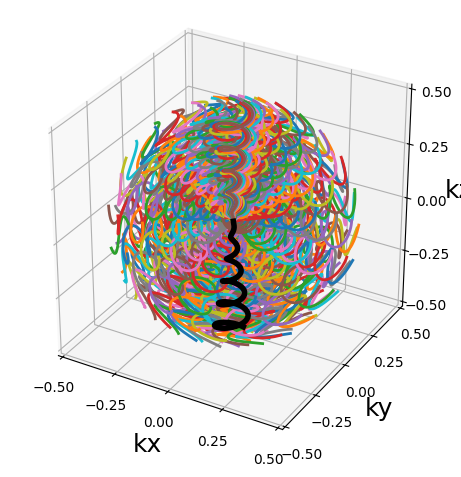

/srv/conda/envs/notebook/lib/python3.10/site-packages/mrinufft/operators/base.py:376: UserWarning: Data should be of dtype complex64 (is float32). Casting it for you.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")
/srv/conda/envs/notebook/lib/python3.10/site-packages/mrinufft/_utils.py:41: UserWarning: Samples will be rescaled to [-0.5, 0.5), assuming they were in [-pi, pi)
  warnings.warn(


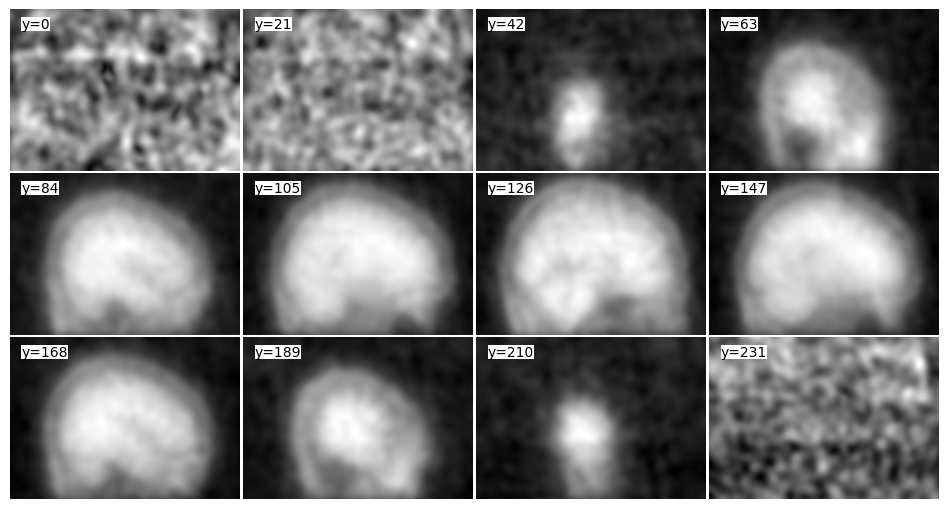

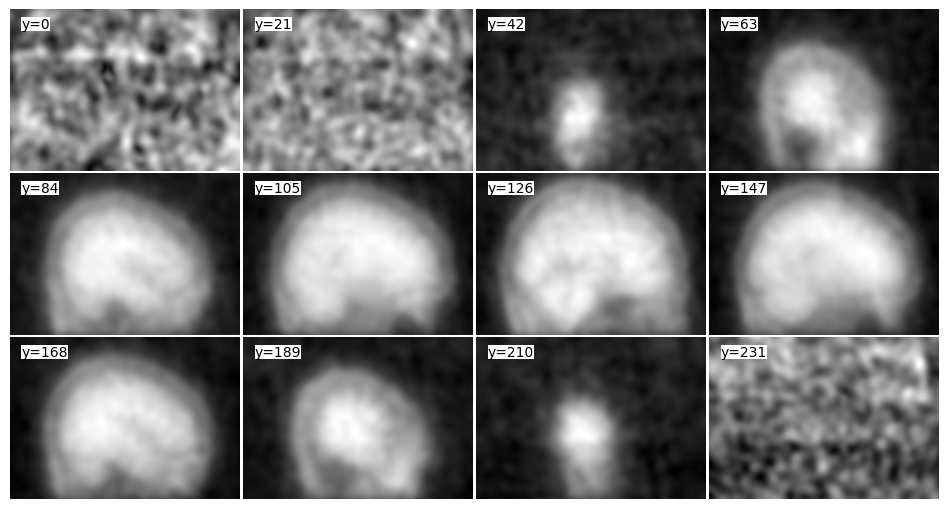

In [6]:
from mrinufft.trajectories import initialize_3D_cones

traj = initialize_3D_cones(256, 256).astype(np.float32)

show_trajectory(traj, 10, (15, 5))

nufft = get_operator("finufft")(traj, mri_3D.shape, density=False)
kspace = nufft.op(mri_3D)
adjoint_3Dcones = nufft.adj_op(kspace)
#tile_view(adjoint_3Dcones, samples=0.05, axis=-1)

cell_weights = get_density("cell_count", traj, shape=mri_3D.shape, osf=2.0)
nufft_cell_counting = get_operator("finufft")(
    traj, shape=mri_3D.shape, density=cell_weights, upsampfac=2.0
)
dc_adjoint_3Dcones = nufft_cell_counting.adj_op(kspace)
tile_view(dc_adjoint_3Dcones, samples=0.05, axis=-1)

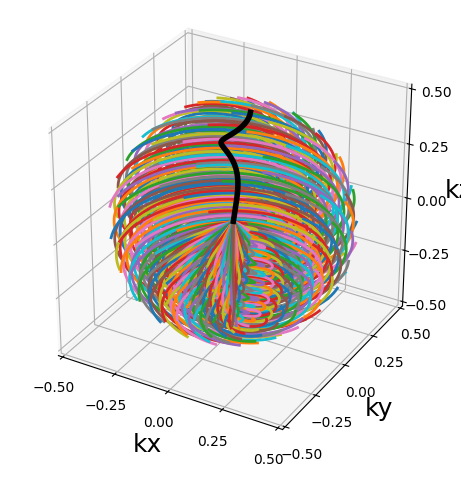

/srv/conda/envs/notebook/lib/python3.10/site-packages/mrinufft/_utils.py:36: UserWarning: Samples will be rescaled to [-pi, pi), assuming they were in [-0.5, 0.5)
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/mrinufft/operators/base.py:376: UserWarning: Data should be of dtype complex64 (is float32). Casting it for you.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")


In [7]:
from mrinufft.trajectories import initialize_3D_floret

traj = initialize_3D_floret(256, 256).astype(np.float32)
show_trajectory(traj, 10, (15, 5))

nufft = get_operator("finufft")(traj, mri_3D.shape, density=False)
kspace = nufft.op(mri_3D)
adjoint_3Dfloret = nufft.adj_op(kspace)
#tile_view(adjoint_3Dfloret, samples=0.05, axis=-1)

#cell_weights = get_density("cell_count", traj, shape=mri_3D.shape, osf=2.0)
#nufft_cell_counting = get_operator("finufft")(
#    traj, shape=mri_3D.shape, density=cell_weights, upsampfac=2.0
#)
#dc_adjoint_3Dfloret = nufft_cell_counting.adj_op(kspace)
#tile_view(dc_adjoint_3Dfloret, samples=0.05, axis=-1)

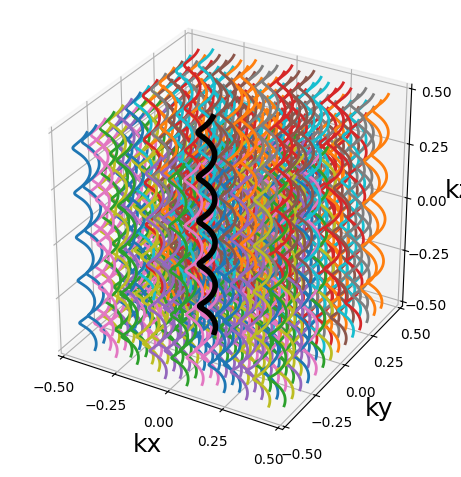

/srv/conda/envs/notebook/lib/python3.10/site-packages/mrinufft/_utils.py:36: UserWarning: Samples will be rescaled to [-pi, pi), assuming they were in [-0.5, 0.5)
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/mrinufft/operators/base.py:376: UserWarning: Data should be of dtype complex64 (is float32). Casting it for you.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")


In [ ]:
from mrinufft.trajectories import initialize_3D_wave_caipi

traj = initialize_3D_wave_caipi(256, 256).astype(np.float32)
show_trajectory(traj, 10, (15, 5))

nufft = get_operator("finufft")(traj, mri_3D.shape, density=False)
kspace = nufft.op(mri_3D)
adjoint_3Dwave_caipi = nufft.adj_op(kspace)
tile_view(adjoint_3Dwave_caipi, samples=0.05, axis=-1)

voronoi_weights = get_density("voronoi", traj)
nufft3D_voronoi = get_operator("finufft")(
    traj, shape=mri_3D.shape, density=voronoi_weights
)
dc_adjoint_3Dwave_caipi = nufft3D_voronoi.adj_op(kspace)

#cell_weights = get_density("cell_count", traj, shape=mri_3D.shape, osf=2.0)
##nufft_cell_counting = get_operator("finufft")(
#    traj, shape=mri_3D.shape, density=cell_weights, upsampfac=2.0
#)
#dc_adjoint_3Dwave_caipi = nufft_cell_counting.adj_op(kspace)
tile_view(dc_adjoint_3Dwave_caipi, samples=0.05, axis=-1)

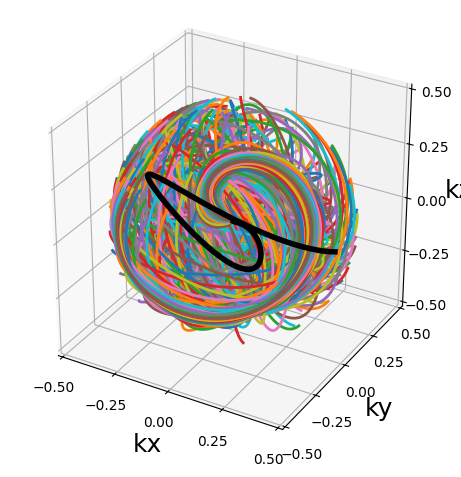

/srv/conda/envs/notebook/lib/python3.10/site-packages/mrinufft/_utils.py:36: UserWarning: Samples will be rescaled to [-pi, pi), assuming they were in [-0.5, 0.5)
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/mrinufft/operators/base.py:376: UserWarning: Data should be of dtype complex64 (is float32). Casting it for you.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/finufft/_interfaces.py:329: UserWarning: Argument `data` does not satisfy the following requirement: C. Copying array (this may reduce performance)
  warnings.warn(f"Argument `{name}` does not satisfy the following requirement: {prop}. Copying array (this may reduce performance)")


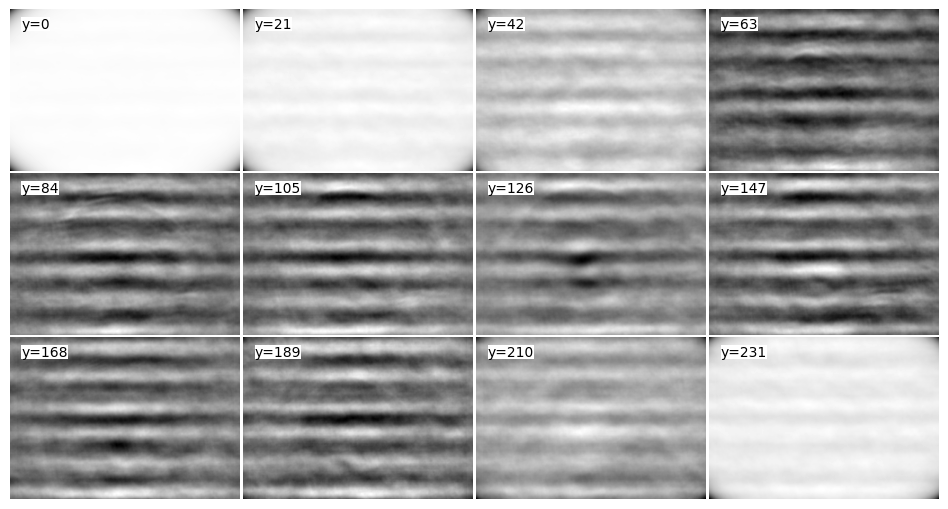

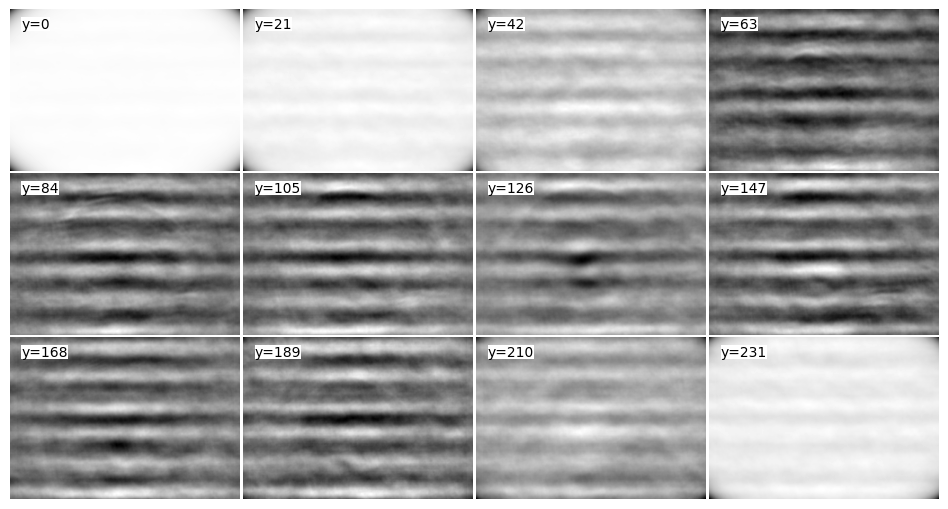

In [8]:
from mrinufft.trajectories import initialize_3D_seiffert_spiral

traj = initialize_3D_seiffert_spiral(256, 256).astype(np.float32)
show_trajectory(traj, 10, (15, 5))

nufft = get_operator("finufft")(traj, mri_3D.shape, density=False)
kspace = nufft.op(mri_3D)
adjoint_3D_seiffert_spiral = nufft.adj_op(kspace)
tile_view(adjoint_3D_seiffert_spiral, samples=0.05, axis=-1)
